In [ ]:
## Ref: https://www.kaggle.com/andradaolteanu/birdcall-recognition-eda-and-audio-fe

In [3]:
from google.colab import drive
drive.mount('/content/drive/')
root_path = '/content/drive/My Drive/Colab Notebooks/Fuglakall/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
## https://www.kaggle.com/tarunpaparaju/birdcall-identification-spectrogram-resnet#Preparing-the-ground-
!pip install -q pydub
!pip install -q colored
!pip install geopandas
!pip install ffmpeg
!pip install numpy
!pip uninstall -y mxnet
!pip install mxnet-cu100==1.4.0.post0
print('complete')

     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 1.0MB 18.6MB/s 
     |████████████████████████████████| 6.5MB 48.1MB/s 
     |████████████████████████████████| 14.8MB 196kB/s 
  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp37-none-any.whl size=6083 sha256=11073591fbe33dba6a91512cc239d5c1b379a5c0ec3165d42e1be81ccf1b589c
  Stored in directory: /root/.cache/pip/wheels/b6/68/c3/a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg
     |████████████████████████████████| 487.9MB 37kB/s 
     |████████████████████████████████| 13.8MB 241kB/s 
ERROR: xarray 0.15.1 has requirement numpy>=1.15, but you'll have numpy 1.14.6 which is incompatible.
ERROR: umap-learn 0.5.1 has requirement numpy>=1.17, but you'll have numpy 1.14.6 which is incompatible.
ERROR: tifffile 2021.3.5 has requirement numpy>=1.15.1, but you'll have numpy 1.14.6 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have

complete


In [5]:
!nvidia-smi

Thu Mar 18 02:45:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
##

# Our Libraries
import sys
sys.version

import os
import gc
import cv2
import time
import IPython
import IPython.display as ipd
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# Map 1 
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# Map 2 
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon


import pydub
from pydub import AudioSegment as AS
from tqdm.notebook import tqdm
from colored import fg, bg, attr

import librosa
import librosa.display
from librosa.feature import melspectrogram
from librosa.core import power_to_db as ptdb

import torch
import torch.nn as nn
from torch.optim import Adam
from albumentations import Normalize
from torchvision.models import resnet34
from torch.utils.data import Dataset, DataLoader
from torch import FloatTensor, LongTensor, DoubleTensor

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences as pad


import warnings
warnings.filterwarnings('ignore')


print(torch.cuda.is_available())
print(tf.test.gpu_device_name())
print("done")

True
/device:GPU:0
done


### Hyperparameters

In [7]:
torch.backends.cudnn.benchmark = True


## define hyperparameters
F = 512
DROP = 0.2
EPOCHS = 20
LR = 1e-3, 1e-2
VAL_BATCH_SIZE = 16
TRAIN_BATCH_SIZE = 16

MAX_OUTPUTS = 3
THRESHOLD = 6e-3
MIN_THRESHOLD = 5e-3

SR = 44100
CHUNKS = 1
TSR = 32000
SPLIT = 0.8
N_MELS = 100 #256
MEL_LEN = 500 #1954
POP_FRAC = 0.25
MAXLEN = 1000000
AMPLITUDE = 1000
CHUNK_SIZE = 1000000

print("continue")

continue


### Paths

In [8]:

#!unzip 'drive/My Drive/Colab Notebooks/Fuglakall/prepare-check-dataset.zip'
#!unzip 'drive/My Drive/Colab Notebooks/Fuglakall/birdcall-identification-spectrogram-loader/train_4.zip'

# os.listdir('drive/My Drive/Colab Notebooks/Fuglakall/')
## birdsong-recognition
## prepare-check-dataset
## birdcall-identification-spectrogram-loader


In [9]:
## PATHS to CSV and AUDIO
## https://www.kaggle.com/shonenkov/prepare-check-dataset/data
TEST_DATA_PATH =  'drive/My Drive/Colab Notebooks/Fuglakall/birdcall-check/test_.csv'
                  # 'drive/My Drive/Colab Notebooks/Fuglakall/test.csv'
TRAIN_DATA_PATH = 'drive/My Drive/Colab Notebooks/Fuglakall/train.csv'
TEST_AUDIO_PATH = 'drive/My Drive/Colab Notebooks/Fuglakall/test_audio_cp/'
TRAIN_AUDIO_PATH = 'drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full/'
CHECKING_PATH = 'drive/My Drive/Colab Notebooks/Fuglakall/birdcall-check/' 
IMG_PATHS = ['drive/My Drive/Colab Notebooks/Fuglakall/birdcall-identification-spectrogram-loader/train_1', 
             'drive/My Drive/Colab Notebooks/Fuglakall/birdcall-identification-spectrogram-loader/train_2', 
             'drive/My Drive/Colab Notebooks/Fuglakall/birdcall-identification-spectrogram-loader/train_3', 
             'drive/My Drive/Colab Notebooks/Fuglakall/birdcall-identification-spectrogram-loader/train_4', 
             'drive/My Drive/Colab Notebooks/Fuglakall/birdcall-identification-spectrogram-loader/train_5']
DIR_PATH = 'drive/My Drive/Colab Notebooks/Fuglakall/birdcall-identification-spectrogram-loader/'
        
sub = os.path.exists(TEST_AUDIO_PATH)
species_ = ['Alder Flycatcher', 'American Crow', 'Barred Owl', 'Great Horned Owl', 'Mourning Dove', 'Semipalmated Plover'] #  'Belted Kingfisher', 
TEST_DATA_PATH = TEST_DATA_PATH if sub else CHECKING_PATH + 'test_.csv'
TEST_AUDIO_PATH = TEST_AUDIO_PATH if sub else CHECKING_PATH + 'test_audio/'


## IMPORT / LOAD DATA
test_df = pd.read_csv(TEST_DATA_PATH)
train_df = pd.read_csv(TRAIN_DATA_PATH)


ebcode = list(train_df[train_df.species.isin(species_)].ebird_code.unique()) 
print(ebcode)
print('continue')

['aldfly', 'amecro', 'brdowl', 'grhowl', 'moudov', 'semplo']
continue


In [10]:

PATH_DICT = {}
for folder_path in tqdm(IMG_PATHS):
    for img_path in os.listdir(folder_path):
      #temp = str(img_path).split('.jpg')[0]
      #if temp in contents:
        PATH_DICT[img_path] = folder_path + '/'

#test_df.head()
len(PATH_DICT) #21375

21375

In [11]:
## CLEAN DATA

def convert_keys_to_string(dictionary):
    """Recursively converts dictionary keys to strings."""
    if not isinstance(dictionary, dict):
        return dictionary
    return dict((str(k), convert_keys_to_string(v)) 
        for k, v in dictionary.items())


# Only keep species we care about 
train_df = train_df[train_df.species.isin(species_)]
#train_df.length # 633

# Only keep good scores
train_df = train_df[train_df.rating >= 3]
train_df.species.unique()
print(train_df.species.unique()) # 594


# GET LIST OF FILENAMES IN PATH_DICT
fnames = list(convert_keys_to_string(PATH_DICT.keys()))
contents = [(lambda x: x.split('.jpg')[0])(x) for x in fnames] #.apply(lambda x: x.split('.jpg')[0])
# print(contents)
print(len(contents)) # 21375

# MODIFY LISTS of FILENAMES TO KEEP & DISCARD
contents_ = []
contents_rm = []

for i in contents:
  if i in list(train_df.filename.unique()):
    contents_.append(i)
  else:
    contents_rm.append(i)

print(len(contents_)) # 594
print(len(contents_rm)) # 20781

# REMOVE DESIGNATED PATHS FROM PATH_DICT
for key in list(PATH_DICT):
    if str(key.split('.jpg')[0]) in contents_rm: 
        del PATH_DICT[key]


print(len(list(PATH_DICT.keys()))) #594

['Alder Flycatcher' 'American Crow' 'Barred Owl' 'Great Horned Owl'
 'Mourning Dove' 'Semipalmated Plover']
21375
543
20832
543


In [12]:
print(train_df.filename.count()) ###394 ##200 #594
#train_df.head()

543


#### helper script 
(generates test.csv)

In [15]:
#!mkdir 'drive/m/birdcall-check'
#!mkdir 'drive/m/birdcall-check/test_audio'
df_train = train_df # w train path: drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full

def copy_audio(ebird_code, filename, audio_id):
    !cp 'drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full/{ebird_code}/{filename}' 'drive/My Drive/Colab Notebooks/Fuglakall/birdcall-check/test_audio_cp/{audio_id}.mp3'

data_check = []
"""
for _, row in df_train[:5].iterrows():
    site = 'site_1'
    audio_id = str(uuid4()).replace('-', '')
    print(row['ebird_code'])
    copy_audio(row['ebird_code'], row['filename'], audio_id)
    for i in range(row['duration']//5):
        seconds = int((i + 1)*5)
        row_id = f'{site}_{audio_id}_{seconds}'
        data_check.append({
            'site': site,
            'row_id': row_id,
            'seconds': seconds,
            'audio_id': audio_id
        })
        
for _, row in df_train[5:10].iterrows():
    site = 'site_2'
    audio_id = str(uuid4()).replace('-', '')
    copy_audio(row['ebird_code'], row['filename'], audio_id)
    for i in range(row['duration']//5):
        seconds = int((i + 1)*5)
        row_id = f'{site}_{audio_id}_{seconds}'
        data_check.append({
            'site': site,
            'row_id': row_id,
            'seconds': seconds,
            'audio_id': audio_id
        })
        
for _, row in df_train[10:15].iterrows():
    site = 'site_3'
    audio_id = str(uuid4()).replace('-', '')
    copy_audio(row['ebird_code'], row['filename'], audio_id)
    seconds = None
    row_id = f'{site}_{audio_id}'
    data_check.append({
        'site': site,
        'row_id': row_id,
        'seconds': seconds,
        'audio_id': audio_id
    })


data_check = pd.DataFrame(data_check)
data_check.to_csv('drive/My Drive/Colab Notebooks/Fuglakall/birdcall-check/test_.csv', index=False)
data_check.head()
"""
 #test_df
data_check = pd.read_csv('drive/My Drive/Colab Notebooks/Fuglakall/birdcall-check/test_.csv')

In [17]:
#test_df = pd.read_csv('drive/My Drive/Colab Notebooks/Fuglakall/birdcall-check/test_.csv')
test_df = data_check
test_df.head(3)

,site,row_id,seconds,audio_id
0,site_1,site_1_2364216b754f4c46b28520c28deff021_5,5.0,2364216b754f4c46b28520c28deff021
1,site_1,site_1_2364216b754f4c46b28520c28deff021_10,10.0,2364216b754f4c46b28520c28deff021
2,site_1,site_1_2364216b754f4c46b28520c28deff021_15,15.0,2364216b754f4c46b28520c28deff021


In [18]:
## MAKE COPY of DATASETS
train_csv = train_df
test_csv = test_df

## STORE SOME ID / KEY VALUES
keys = set(train_df.ebird_code)
values = np.arange(0, len(keys))
code_dict = dict(zip(sorted(keys), values))

# BIRD COUNT per SPECIES
counts = [list(train_df.ebird_code).count(code) for code in set(train_df.ebird_code)]
idx = np.argsort(counts)
print('okii')

okii


### Train.csv Visualization

> 📌**Note**:
* Bird count per species in dataset
* Duration


In [ ]:
## LETS GET TO KNOW OUR DATA...

# BIRD COUNT per SPECIES
#counts = [list(train_df.ebird_code).count(code) for code in set(train_df.ebird_code)]
#idx = np.argsort(counts)
df = pd.DataFrame(np.transpose([np.array(list(set(train_df.ebird_code)))[idx], np.array(counts)[idx]]))
df.columns = ["Bird species", "Count"]
fig = px.bar(df, x="Count", y="Bird species", title="Bird species vs. Count", template="simple_white")
fig.data[0].orientation = 'h'
fig.update_layout(height=1800, paper_bgcolor="#edebeb")
fig.update_traces(textfont=dict(
        color="white"
    ))
fig.show()
#df.head()

In [ ]:
# Create a new variable type by exploding all the values
adjusted_type = train_df['type'].apply(lambda x: x.split(',')).reset_index().explode("type")

# Strip of white spaces and convert to lower chars
adjusted_type = adjusted_type['type'].apply(lambda x: x.strip().lower()).reset_index()
adjusted_type['type'] = adjusted_type['type'].replace('calls', 'call')



# Create Top 15 list with song types
top_15 = list(adjusted_type['type'].value_counts().head(15).reset_index()['index'])
data = adjusted_type[adjusted_type['type'].isin(top_15)]

# Plot
plt.figure(figsize=(16, 6))
ax = sns.countplot(data['type'], palette="hls", order = data['type'].value_counts().index)

plt.title("Top 15 Song Types", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");


## Disc: Here we decide we should remove 'flight call' 'wing noise' 'wingbeats' and MAYBE 'duet' from training

In [ ]:
## == WHERE IS THE BIRD? ==
## Note: In most recordings the birds were seen, usually at an altitude between 0m and 10m.

# Top 15 most common elevations
top_15 = list(train_df['elevation'].value_counts().head(15).reset_index()['index'])
data = train_csv[train_df['elevation'].isin(top_15)]

# PLOT 
plt.figure(figsize=(16, 6))
ax = sns.countplot(data['elevation'], palette="hls", order = data['elevation'].value_counts().index)

plt.title("Top 15 Elevation Types", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

In [ ]:
# Create data
data = train_df['bird_seen'].value_counts().reset_index()

#PLOT
xy = (0.5, 0.7)
plt.figure(figsize=(16, 6))
ax = sns.barplot(x = 'bird_seen', y = 'index', data = data, palette="hls")

plt.title("Was Bird Seen?", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

## Disc: Should we remove not seen?

In [ ]:
## RECORDINGS per COUNTRY
# not rly applicable to our interests
"""
# Top 15 most common Countries
top_15 = list(train_csv['country'].value_counts().head(15).reset_index()['index'])
data = train_csv[train_csv['country'].isin(top_15)]

#PLOT
xy = (0.5, 0.7)
plt.figure(figsize=(16, 6))
ax = sns.countplot(data['country'], palette='hls', order = data['country'].value_counts().index)

plt.title("Top 15 Countries with most Recordings", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

# Import gapminder data, where we have country and iso ALPHA codes
df = px.data.gapminder().query("year==2007")[["country", "iso_alpha"]]

# Merge the tables together (we lose a fiew rows, but not many)
data = pd.merge(left=train_csv, right=df, how="inner", on="country")

# Group by country and count how many species can be found in each
data = data.groupby(by=["country", "iso_alpha"]).count()["species"].reset_index()

fig = px.choropleth(data, locations="iso_alpha", color="species", hover_name="country",
                    color_continuous_scale=px.colors.sequential.Teal,
                    title = "World Map: Recordings per Country")
fig.show()
"""

In [ ]:
## DURATION

## DISTRIBUTION GRAPH
nums_1 = train_df.duration
nums_1 = nums_1.fillna(nums_1.mean())

fig = ff.create_distplot(hist_data=[nums_1],
                         group_labels=["0"],
                         colors=["seagreen"], show_hist=False)

fig.update_layout(title_text="Duration distribution", xaxis_title="Duration",
                  template="plotly_white", paper_bgcolor="#edebeb")
fig.show()



## BAR GRAPH
# Creating Interval for *duration* variable
train_df['duration_interval'] = ">500"
train_df.loc[train_df['duration'] <= 100, 'duration_interval'] = "<=100"
train_df.loc[(train_df['duration'] > 100) & (train_df['duration'] <= 200), 'duration_interval'] = "100-200"
train_df.loc[(train_df['duration'] > 200) & (train_df['duration'] <= 300), 'duration_interval'] = "200-300"
train_df.loc[(train_df['duration'] > 300) & (train_df['duration'] <= 400), 'duration_interval'] = "300-400"
train_df.loc[(train_df['duration'] > 400) & (train_df['duration'] <= 500), 'duration_interval'] = "400-500"

xy = (0.5, 0.7)
plt.figure(figsize=(16, 6))
ax = sns.countplot(train_df['duration_interval'], palette="hls")

plt.title("Distribution of Recordings Duration", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");


## Disc: Should we remove those with duration > 200 ?

In [ ]:
## PITCH

## NOTE: Pitch is usually unspecified. 
## This is one of the more miscellaneous columns, that we need to be careful how we interpret. Most Song Types are call, song or flight
##


## BAR GRAPH 
plt.figure(figsize=(16, 6))
ax = sns.countplot(train_df['pitch'], palette="hls", order = train_df['pitch'].value_counts().index)

plt.title("Pitch (quality of sound - how high/low the tone is)", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("");

plt.show()

## PIE GRAPH
counts = [list(train_df.pitch).count(code) for code in set(train_df.pitch)]
df = pd.DataFrame(np.transpose([list(set(train_df.pitch)), counts]))
df.columns = ["Pitch", "Count"]
fig = px.pie(df, names="Pitch", values="Count", title="Pitch", color_discrete_sequence=list(reversed(px.colors.cyclical.Edge)))
fig.update_layout(paper_bgcolor="#edebeb")
fig.update_traces(textfont=dict(
        color="white"
    ))
fig.show()

In [ ]:
## TIME of RECORDING
## 00 is for the dates 0000-00-00, which are unknown

# Create some time features
train_df['year'] = train_df['date'].apply(lambda x: x.split('-')[0])
train_df['month'] = train_df['date'].apply(lambda x: x.split('-')[1])
train_df['day_of_month'] = train_df['date'].apply(lambda x: x.split('-')[2])

contents = ['Alder Flycatcher', 'American Crow', 'Barred Owl', 'Belted Kingfisher', 'Great Horned Owl', 'Mourning Dove', 'Semipalmated Plover']
print("There are {:,} unique bird species in this dataset: ".format(len(train_df['species'].unique())))

"""
## AUDIO FILES REG per YEAR
plt.figure(figsize=(16, 6))
ax = sns.countplot(train_df['year'], palette="hls", order = train_df['year'].value_counts().index)

plt.title("Audio Files Registration per Year Made", fontsize=16)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("");

## AUDIO FILES REG per MONTH
plt.figure(figsize=(16, 6))
ax = sns.countplot(train_df['month'], palette="hls") #, order = train_csv['month'].value_counts().index)

plt.title("Audio Files Registration per Month Made", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("");
"""

In [ ]:
## CHANNELS
## indicates the number of channels in the audio clip (1: mono or 2: stereo).
counts = [list(train_df.channels).count(code) for code in set(train_df.channels)]
df = pd.DataFrame(np.transpose([list(set(train_df.channels)), counts]))
df.columns = ["Channels", "Count"]
colors = px.colors.qualitative.Plotly
fig = px.pie(df, names="Channels", values="Count", title="Channels", color_discrete_sequence=["darkblue", "SteelBlue"])
fig.update_layout(paper_bgcolor="#edebeb")
fig.update_traces(textfont=dict(
        color="white"
    ))
fig.show()

## somewhat even split. deal with this by concatenating the multiple channels into a single signal (mono)

In [ ]:
## ADDITIONAL CLEAN ? TO DO

## remove call types

## remove bird not seen

## remove bird too far

## remove duration > 200 

### FILE CONVERSIONS



In [ ]:

## convert mp3 to wav
import subprocess 
import sys
#sys.path.append('/path/to/ffmpeg')

from os import path
from pydub import AudioSegment 

"""
# mp3 file path
mpath = os.fspath(amecro)

# get file name
fname = os.path.basename(os.path.normpath(mpath)).strip('.mp3')

# get base path
bpath = mpath.strip(fname+'.mp3')

# set new path to converted wav file
wpath = fname.strip('.mp3')+'.wav'

# assign files 
src = mpath
dst = bpath+wpath
#print(src)
#print(dst)

# convert mp3 file to wav file 

# convert wav to mp3     
#AudioSegment.converter = '/usr/local/Cellar/ffmpeg/4.3.2/bin/ffmpeg'
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

subprocess.call(['ffmpeg', '-i', mpath, wpath])
"""


### TEST.csv - let's take a look here as well before going further

> 📌**Note**:
* only 3 rows available (rest are in the hidden set)
* `site`: there are 3 sites in total, with first 2 having labeles every 5 seconds, while site_3 has labels at file level.
* `row_id`: this is the unique ID that will be used for the submission
* `seconds`: how long the clip is
* `audio_id`: `row_id` without site

*PS: "nocall" can be also one of the labels (hearing no bird).*

In [19]:
# https://www.kaggle.com/shonenkov/prepare-check-dataset/notebook

import pandas as pd
from uuid import uuid4

# Inspect text_csv before checking train data

# Overview of a few lines
test_csv.head(3)

,site,row_id,seconds,audio_id
0,site_1,site_1_2364216b754f4c46b28520c28deff021_5,5.0,2364216b754f4c46b28520c28deff021
1,site_1,site_1_2364216b754f4c46b28520c28deff021_10,10.0,2364216b754f4c46b28520c28deff021
2,site_1,site_1_2364216b754f4c46b28520c28deff021_15,15.0,2364216b754f4c46b28520c28deff021


In [20]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [21]:
# Create Full Path so we can access data more easily
base_dir = 'drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full/'
train_df['full_path'] = base_dir + train_csv['ebird_code'] + '/' + train_df['filename']

# Now let's sample the audio files for our 5 bird species
bird_sample_list = ebcode
print(bird_sample_list)
print(ebcode)
aldfly = train_df[train_df['ebird_code'] == "aldfly"].sample(1, random_state = 33)['full_path'].values[0]
amecro = train_df[(train_df['ebird_code'] == "amecro")].sample(1, random_state = 33)['full_path'].values[0]
#belkin1 = train_df[train_df['ebird_code'] == "belkin1"].sample(1, random_state = 33)['full_path'].values[0]
brdowl = train_df[train_df['ebird_code'] == "brdowl"].sample(1, random_state = 33)['full_path'].values[0]
grhowl = train_df[train_df['ebird_code'] == "grhowl"].sample(1, random_state = 33)['full_path'].values[0] 
moudov = train_df[train_df['ebird_code'] == "moudov"].sample(1, random_state = 33)['full_path'].values[0]
semplo = train_df[train_df['ebird_code'] == "semplo"].sample(1, random_state = 33)['full_path'].values[0]

print('continue')

['aldfly', 'amecro', 'brdowl', 'grhowl', 'moudov', 'semplo']
['aldfly', 'amecro', 'brdowl', 'grhowl', 'moudov', 'semplo']
continue


In [ ]:
ipd.Audio(amecro)

In [ ]:
ipd.Audio(aldfly)

### SOUND EXTRACTION

In [22]:
# Importing 1 file
y, sr = librosa.load(aldfly)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', np.shape(y)[0]/sr)

y: [-1.0148083e-07  9.2685788e-08 -7.7556493e-08 ... -1.1240407e-05
  2.5074007e-05  3.2757787e-05] 

y shape: (1473408,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 66.82122448979592


In [23]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [-1.0148083e-07  9.2685788e-08 -7.7556493e-08 ... -1.1240407e-05
  2.5074007e-05  3.2757787e-05] 

Audio File shape: (1473408,)


In [24]:
# Importing the 5 files TO DO
y_amecro, sr_amecro = librosa.load(amecro)
audio_amecro, _ = librosa.effects.trim(y_amecro)

y_aldfly, sr_aldfly = librosa.load(aldfly)
audio_aldfly, _ = librosa.effects.trim(y_aldfly)

#y_belkin1, sr_belkin1 = librosa.load(belkin1)
#audio_belkin1, _ = librosa.effects.trim(y_belkin1)

y_brdowl, sr_brdowl = librosa.load(brdowl)
audio_brdowl, _ = librosa.effects.trim(y_brdowl)

y_grhowl, sr_grhowl = librosa.load(grhowl)
audio_grhowl, _ = librosa.effects.trim(y_grhowl)

y_moudov, sr_moudov = librosa.load(moudov)
audio_moudov, _ = librosa.effects.trim(y_moudov)

y_semplo, sr_semplo = librosa.load(semplo)
audio_semplo, _ = librosa.effects.trim(y_semplo)
print('success')

success


In [25]:
## SET UP VARS FOR VIZ

# 2D waveform
nplots = 6

# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

### 2D WAVEFORM

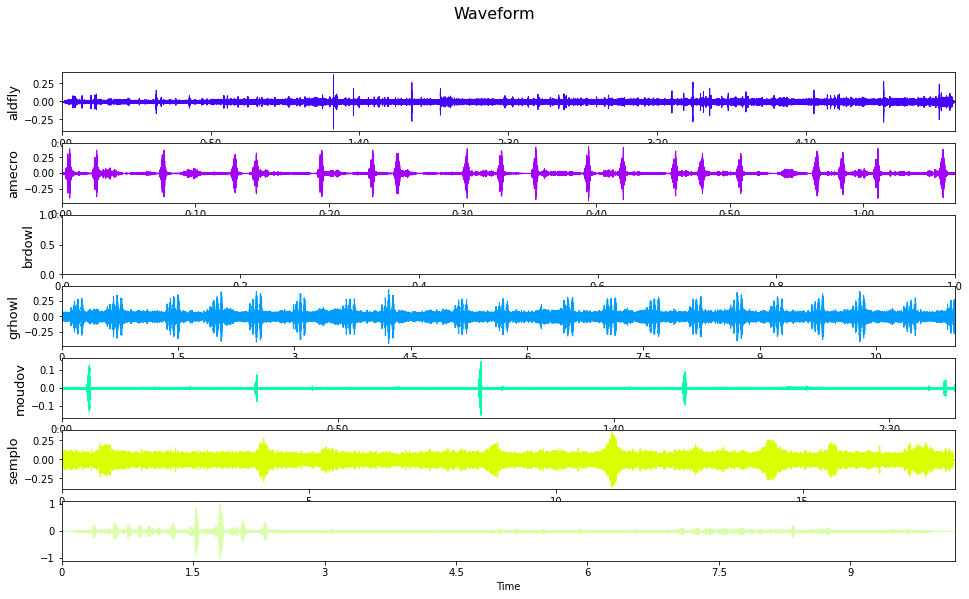

In [27]:

fig, ax = plt.subplots(nplots, figsize = (16, 9))
fig.suptitle('Waveform', fontsize=16)

librosa.display.waveplot(y = audio_amecro, sr = sr_amecro, color = "#4300FF", ax=ax[0])
librosa.display.waveplot(y = audio_aldfly, sr = sr_aldfly, color = "#A300F9", ax=ax[1])
#librosa.display.waveplot(y = audio_belkin1, sr = sr_belkin1, color = "#009D00", ax=ax[2])
librosa.display.waveplot(y = audio_brdowl, sr = sr_brdowl, color = "#009DFF", ax=ax[3])
librosa.display.waveplot(y = audio_grhowl, sr = sr_grhowl, color = "#00FFB0", ax=ax[4])
librosa.display.waveplot(y = audio_moudov, sr = sr_moudov, color = "#D9FF00", ax=ax[5])
librosa.display.waveplot(y = audio_semplo, sr = sr_semplo, color = "#D9FFAA", ax=ax[6]);


for i, name in zip(range(nplots), bird_sample_list):
    ax[i].set_ylabel(name, fontsize=13)

### FOURIER TRANSORM
Default FFT window size:

n_fft = 2048 # FFT window size

hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

Text(0, 0.5, 'Magnitude')

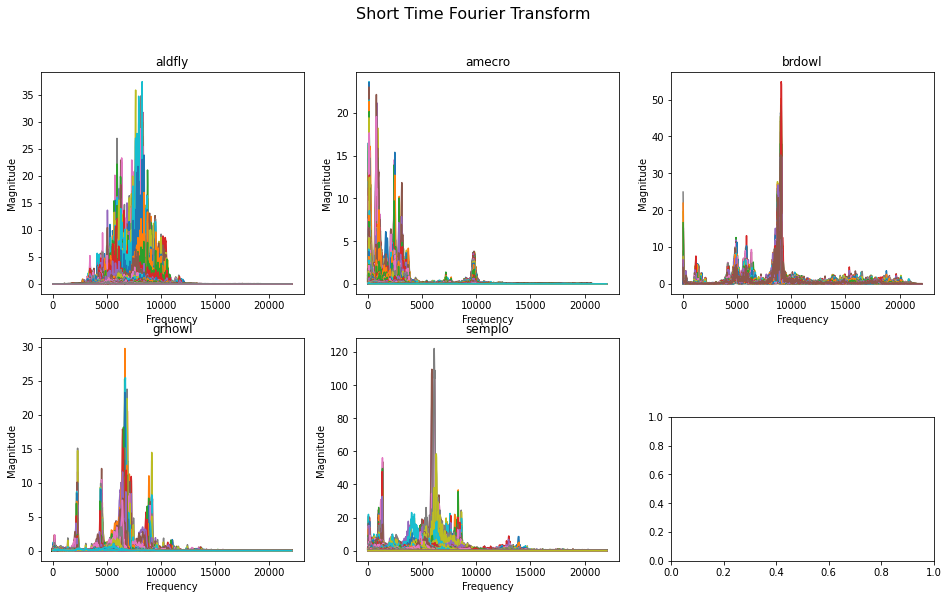

In [28]:
fig, ax = plt.subplots(3, 3, figsize=(16, 9))
fig.suptitle('Short Time Fourier Transform', fontsize=16)
fig.delaxes(ax[1, 2])

# Short-time Fourier transform (STFT)
Magnitude_aldfly = np.abs(librosa.stft(audio_aldfly, n_fft = n_fft, hop_length = hop_length))
Frequency_aldfly = np.linspace(0,sr_aldfly,len(Magnitude_aldfly))
plt.subplot(231)
plt.plot(Frequency_aldfly,Magnitude_aldfly)
plt.title('aldfly')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")

Magnitude_amecro = np.abs(librosa.stft(audio_amecro, n_fft = n_fft, hop_length = hop_length))
Frequency_amecro = np.linspace(0,sr_amecro,len(Magnitude_amecro))
plt.subplot(232)
plt.plot(Frequency_amecro,Magnitude_amecro)
plt.title('amecro')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


Magnitude_brdowl = np.abs(librosa.stft(audio_brdowl, n_fft = n_fft, hop_length = hop_length))
Frequency_brdowl = np.linspace(0,sr_brdowl,len(Magnitude_brdowl))
plt.subplot(233)
plt.plot(Frequency_brdowl,Magnitude_brdowl)
plt.title('brdowl')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


Magnitude_grhowl = np.abs(librosa.stft(audio_grhowl, n_fft = n_fft, hop_length = hop_length))
Frequency_grhowl = np.linspace(0,sr_grhowl,len(Magnitude_grhowl))
plt.subplot(234)
plt.plot(Frequency_grhowl,Magnitude_grhowl)
plt.title('grhowl')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


Magnitude_moudov = np.abs(librosa.stft(audio_moudov, n_fft = n_fft, hop_length = hop_length))
Frequency_moudov = np.linspace(0,sr_moudov,len(Magnitude_moudov))
plt.subplot(235)
plt.plot(Frequency_moudov,Magnitude_moudov)
plt.title('moudov')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")


Magnitude_semplo = np.abs(librosa.stft(audio_semplo, n_fft = n_fft, hop_length = hop_length))
Frequency_semplo = np.linspace(0,sr_semplo,len(Magnitude_semplo))
plt.subplot(235)
plt.plot(Frequency_semplo,Magnitude_semplo)
plt.title('semplo')
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
## Disc: signal decomposes into several waves that differ according to the species of birds, making it possible to differentiate them.

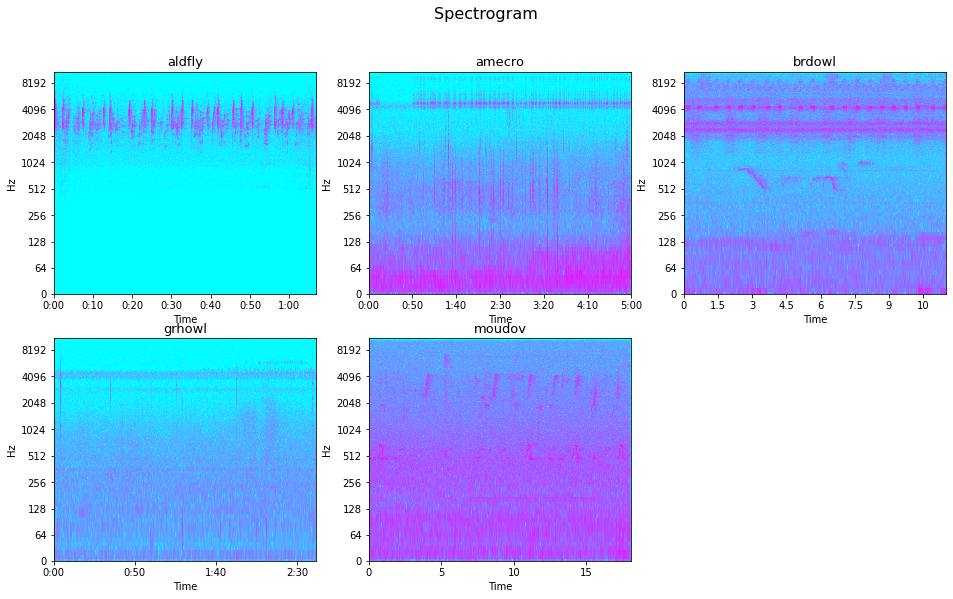

In [29]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_aldfly = librosa.amplitude_to_db(Magnitude_aldfly, ref = np.max)
DB_amecro = librosa.amplitude_to_db(Magnitude_amecro, ref = np.max)
DB_brdowl = librosa.amplitude_to_db(Magnitude_brdowl, ref = np.max)
DB_grhowl = librosa.amplitude_to_db(Magnitude_grhowl, ref = np.max)
DB_moudov = librosa.amplitude_to_db(Magnitude_moudov, ref = np.max)
DB_semplo = librosa.amplitude_to_db(Magnitude_semplo, ref = np.max)


# === PLOT ===
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Spectrogram', fontsize=16)
fig.delaxes(ax[1, 2])

librosa.display.specshow(DB_aldfly, sr = sr_aldfly, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[0, 0])
librosa.display.specshow(DB_amecro, sr = sr_amecro, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[0, 1])
librosa.display.specshow(DB_brdowl, sr = sr_brdowl, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[0, 2])
librosa.display.specshow(DB_grhowl, sr = sr_grhowl, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[1, 0])
librosa.display.specshow(DB_moudov, sr = sr_moudov, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[1, 1]);
librosa.display.specshow(DB_semplo, sr = sr_semplo, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax[1, 2]);


for i, name in zip(range(0, 2*3), bird_sample_list):
    x = i // 3
    y = i % 3
    ax[x, y].set_title(name, fontsize=13) 

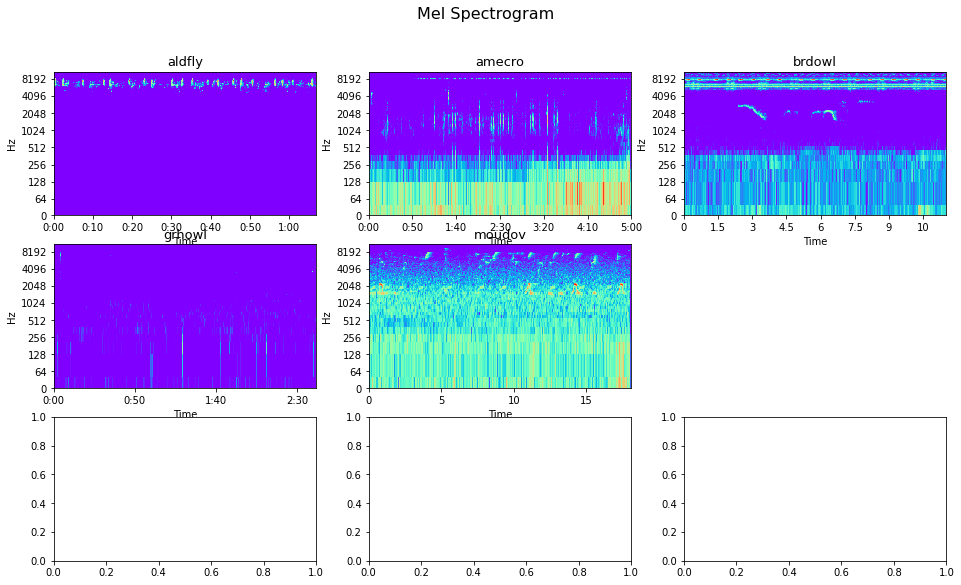

In [30]:
# Create the Mel Spectrograms
S_aldfly = librosa.feature.melspectrogram(y_aldfly, sr=sr_aldfly)
S_DB_aldfly = librosa.amplitude_to_db(S_aldfly, ref=np.max)

S_amecro = librosa.feature.melspectrogram(y_amecro, sr=sr_amecro)
S_DB_amecro = librosa.amplitude_to_db(S_amecro, ref=np.max)

#S_belkin1 = librosa.feature.melspectrogram(y_belkin1, sr=sr_belkin1)
#S_DB_belkin1 = librosa.amplitude_to_db(S_belkin1, ref=np.max)

S_brdowl = librosa.feature.melspectrogram(y_brdowl, sr=sr_brdowl)
S_DB_brdowl = librosa.amplitude_to_db(S_brdowl, ref=np.max)

S_grhowl = librosa.feature.melspectrogram(y_grhowl, sr=sr_grhowl)
S_DB_grhowl = librosa.amplitude_to_db(S_grhowl, ref=np.max)

S_moudov = librosa.feature.melspectrogram(y_moudov, sr=sr_moudov)
S_DB_moudov = librosa.amplitude_to_db(S_moudov, ref=np.max)

S_semplo = librosa.feature.melspectrogram(y_semplo, sr=sr_semplo)
S_DB_semplo = librosa.amplitude_to_db(S_semplo, ref=np.max)


# === PLOT ====
fig, ax = plt.subplots(3, 3, figsize=(16, 9))
fig.suptitle('Mel Spectrogram', fontsize=16)
fig.delaxes(ax[1, 2])



librosa.display.specshow(S_DB_aldfly, sr = sr_aldfly, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[0, 0])
librosa.display.specshow(S_DB_amecro, sr = sr_amecro, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[0, 1])
#librosa.display.specshow(S_DB_belkin1, sr = sr_belkin1, hop_length = hop_length, x_axis = 'time', 
#                         y_axis = 'log', cmap = 'rainbow', ax=ax[0, 2])
librosa.display.specshow(S_DB_brdowl, sr = sr_brdowl, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[0, 2])
librosa.display.specshow(S_DB_grhowl, sr = sr_grhowl, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[1, 0])
librosa.display.specshow(S_DB_moudov, sr = sr_moudov, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[1, 1])
librosa.display.specshow(S_DB_semplo, sr = sr_semplo, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'rainbow', ax=ax[1, 2])


for i, name in zip(range(0, 2*3), bird_sample_list):
    x = i // 3
    y = i % 3
    ax[x, y].set_title(name, fontsize=13)

### **MFCCs**

aka, Mel Frequency Cepstral Coefficients (MFCCs)

"MFCCs capture timbral and textural aspects of sound. For extracting MFCCs, we perform a Fourier Transform to move frome the time domain to the frequency domain so MFCCs are frequency domain features. The great advantage of MFCCs over spectrogram is that they approximate the human auditory system, they try to model the way we perceive frequency. In deep learning it is really important to have some data that represent the way human process audio. The result of extracting MFCCs is a MCC vector which contain between 13 to 40 coefficients. These coefficients are calculated at each frame so we have an idea to how the MFCCs are evolving over time. "

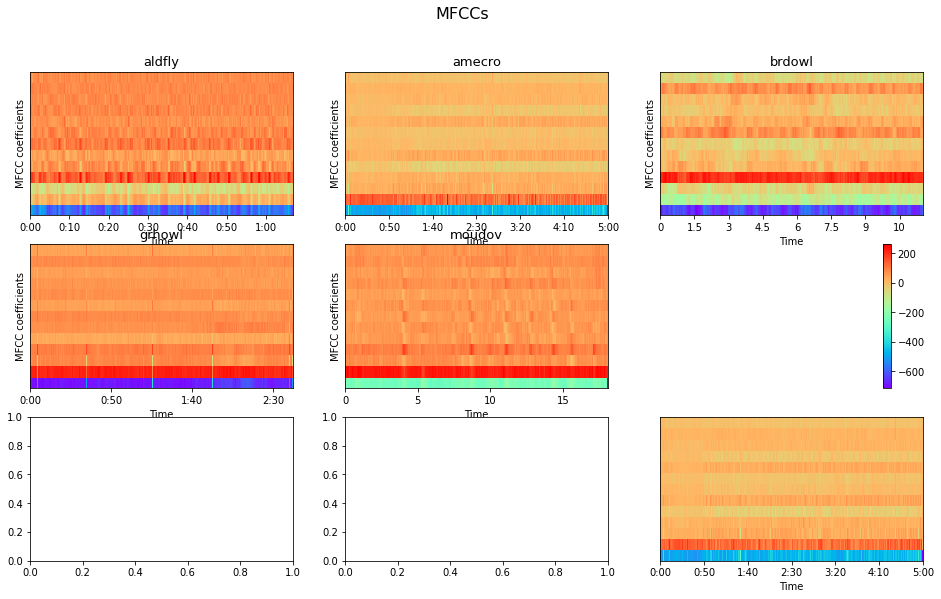

In [31]:
MFCCs_aldfly = librosa.feature.mfcc(audio_aldfly, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
MFCCs_amecro = librosa.feature.mfcc(audio_amecro, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
#MFCCs_belkin1 = librosa.feature.mfcc(audio_belkin1, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
MFCCs_brdowl = librosa.feature.mfcc(audio_brdowl, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
MFCCs_grhowl = librosa.feature.mfcc(audio_grhowl, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
MFCCs_moudov = librosa.feature.mfcc(audio_moudov, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
MFCCs_semplo = librosa.feature.mfcc(audio_semplo, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)


#### PLOT ### 

fig, ax = plt.subplots(3, 3, figsize=(16, 9))
fig.suptitle('MFCCs', fontsize=16)
fig.delaxes(ax[1, 2])

librosa.display.specshow(MFCCs_aldfly, sr=sr_aldfly, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[0, 0])
librosa.display.specshow(MFCCs_amecro, sr=sr_amecro, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[0, 1])
#librosa.display.specshow(MFCCs_belkin1, sr=sr_belkin1, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[0, 2])
librosa.display.specshow(MFCCs_brdowl, sr=sr_brdowl, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[0, 2])
librosa.display.specshow(MFCCs_grhowl, sr=sr_grhowl, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[1, 0])
librosa.display.specshow(MFCCs_moudov, sr=sr_moudov, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[1, 1])
librosa.display.specshow(MFCCs_semplo, sr=sr_semplo, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[1, 2])

fig.colorbar(mappable=librosa.display.specshow(MFCCs_amecro, sr=sr_amecro, hop_length=hop_length, x_axis = 'time', cmap = 'rainbow', ax=ax[2, 2]), cax=None, ax=ax[1,2])

for i, name in zip(range(0, 7), bird_sample_list):
    x = i // 3
    y = i % 3
    ax[x, y].set_title(name, fontsize=13)
    ax[x, y].set_xlabel('Time')
    ax[x, y].set_ylabel('MFCC coefficients')

### MFCC audio extraction script
(only run once)



In [ ]:
# %% [code]
import json 
import os
import math
import librosa
import warnings
warnings.simplefilter("ignore")
"""
# %% [code]
DATASET_PATH = "drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full/"
#"drive/" + "My Drive" + "/" + "Colab Notebooks" + "/Fuglakall/train_audio_full/"

JSON_PATH = "drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full/train_audio_full_MFCC.json"
SAMPLE_RATE = 22050

TO_PROCESS = ebcode # selection of species (to diminish computation time)

# %% [code]
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, segment_duration=6):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [], # genres
        "labels": [], # a number (corresponding to a genres) : targets that we expect
        "mfcc": [] # will bbe the inputs
    }
    

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:
            print('dirpath:' + dirpath + '... dataset_path:' + dataset_path)

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split('/')[-1]
            print(semantic_label)
            print('to process '+ str(TO_PROCESS))
            # Proceed to data extraction only for few species
            if semantic_label in TO_PROCESS:
            
                data["mapping"].append(semantic_label)
                print("\nProcessing: {}".format(semantic_label))

                # process all audio files in genre sub-dir
                
                num_file = 0
                #print('filenames___\n'+ filenames)
                for f in filenames:
                    num_file += 1
                    
                    # audio file
                    file_path = os.path.join(dirpath, f)
                    is_img = ".jpg" in file_path
                    if not (is_img): 
                      print(file_path)
                      signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE) # audio file in array

                      audio_duration = librosa.get_duration(signal, sr=SAMPLE_RATE) # different duration for each sample
                      num_segments = int(audio_duration // segment_duration) # number of segments the audio can be cut into
                      # we want audios of the same duration to allow comparisons

                      samples_per_segment = int(SAMPLE_RATE * segment_duration)
                      num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
                      # that will be what we study

                      # process all segments of audio file
                      for d in range(num_segments):

                          # calculate start and finish sample for current segment
                          start = samples_per_segment * d  # sample at which the segment begin
                          finish = start + samples_per_segment # sample at which the segment stops

                          # extract mfcc (what we will use)
                          mfcc = librosa.feature.mfcc(signal[start:finish], 
                                                      sample_rate, 
                                                      n_mfcc=num_mfcc, 
                                                      n_fft=n_fft, 
                                                      hop_length=hop_length)
                          mfcc = mfcc.T


                          # store only mfcc feature with expected number of vectors
                          if len(mfcc) == num_mfcc_vectors_per_segment: 
                              data["mfcc"].append(mfcc.tolist())
                              data["labels"].append(i-1)
                              # print("{}, segment:{}".format(file_path, d+1), end = '\r', flush=True)
                              print("processing file {} on {}".format(num_file,len(filenames)), end = '\r', flush=True)

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent = 4)
        print("Data successfully saved !")       


# %% [code]
##### Main program #####
save_mfcc(DATASET_PATH, JSON_PATH, segment_duration=6)

# takes a long time, don't execute it
# Already generated the example we use in the our Artificial neural network
# in pre-generated-data folder (../input/pre-generated-data/pre-generated-data.json)
# data generated with a selection of species from folders : TO_PROCESS = ["aldfly", "belkin1","brdowl","grhowl","moudov"]
"""

### STFT Audio Extractions
(only run once)

In [ ]:

import json 
import os
import math
import librosa
import warnings
import numpy as np
warnings.simplefilter("ignore")

"""
# %% [code]
DATASET_PATH = "drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full/"
#"drive/" + "My Drive" + "/" + "Colab Notebooks" + "/Fuglakall/train_audio_full/"

JSON_PATH = "drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full/train_audio_full_STFT.json"
SAMPLE_RATE = 22050 #SAMPLE_RATE = 22050

TO_PROCESS = bird_sample_list #ebcode # selection of species (to diminish computation time)

# parameters changes because STFTs are much more memory-consuming than MFCCs
def save_stft(dataset_path, json_path, n_fft=512, hop_length=2048, segment_duration=4): 
    """Extracts STFTs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save STFTs
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and STFTs
    data = {
        "mapping": [], # genres
        "labels": [], # a number (corresponding to a genres) : targets that we expect
        "stft": [] # will bbe the inputs
    }
    
    file_count = 0 # keeps teack of the loading process

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split('/')[-1]
            
            # Proceed to data extraction only for few species
            if semantic_label in TO_PROCESS:
                
                # Keeps track of loading process
                file_count = file_count + 1
            
                data["mapping"].append(semantic_label)
                print("\nProcessing: {}".format(semantic_label))

                # process all audio files in genre sub-dir
                
                num_file = 0

                for f in filenames:
                    num_file += 1
                    
                    # audio file
                    file_path = os.path.join(dirpath, f)
                    is_img = ".jpg" in file_path
                    if not (is_img): 
                      signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE) # audio file in array

                      audio_duration = librosa.get_duration(signal, sr=SAMPLE_RATE) # different duration for each sample
                      num_segments = int(audio_duration // segment_duration) # number of segments the audio can be cut into
                      # we want audios of the same duration to allow comparisons

                      samples_per_segment = int(SAMPLE_RATE * segment_duration)
                      num_stft_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
                      # that will be what we study

                      
                      # print("{}, segment:{}".format(file_path, d+1), end = '\r', flush=True)
                      print("processing file {} on {}, folder {} on {}".format(num_file,len(filenames),file_count,len(TO_PROCESS)))
                      
                      # process all segments of audio file
                      for d in range(num_segments):

                          # calculate start and finish sample for current segment
                          start = samples_per_segment * d  # sample at which the segment begin
                          finish = start + samples_per_segment # sample at which the segment stops

                          # extract stft (what we will use)
                          stft = np.abs(librosa.stft(signal[start:finish], 
                                                      n_fft=n_fft, 
                                                      hop_length=hop_length))
                          stft = librosa.amplitude_to_db(stft, ref = np.max)
                          stft = stft.T


                          # store only stft feature with expected number of vectors
                          if len(stft) == num_stft_vectors_per_segment: 
                              data["stft"].append(stft.tolist())
                              data["labels"].append(i-1)


    # save STFTs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent = 4)
        print("Data successfully saved !")  

##### Main program #####
save_stft(DATASET_PATH, JSON_PATH, segment_duration=6)

"""

### DEEP LEARNING

In [32]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow.keras as keras
import time


## CONSTANTS
DATA_PATH_STFT = "drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full/train_audio_full_STFT.json"
DATA_PATH_MFCC = "drive/My Drive/Colab Notebooks/Fuglakall/train_audio_full/train_audio_full_MFCC.json"

# Set seed
np.random.seed(42)

In [33]:
## FUNCTIONS

def load_data(data_path,data_type):
    """Loads dataset from json file.

        :param data_path (str): Path to json file containing data
        :param data_type (str): Choose between mfcc and stft
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # Convert lists to numpy arrays
    X = np.array(data[data_type])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")
    
    # Reseting indexes
    values = list(set(y))
    
    for i in range(len(values)):
        y[y == values[i]] = i
        

    return  X, y
   

def prepare_datasets(dataset, test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param dataset (str): Value in ["MFCC", "STFT"] selects the dataset to use
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """
    
    if (dataset == "MFCC"):
        # load data
        X, y = load_data(DATA_PATH_MFCC,"mfcc")
    
    if (dataset == "STFT"):
        # load data
        X, y = load_data(DATA_PATH_STFT,"stft")    

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def add_axis(X_train, X_validation, X_test):
    """ Add an axis to input sets 
    
    :param X_train (ndarray): Input training set
    :param X_validation (ndarray): Input validation set
    :param X_test (ndarray): Input test set
    
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    """
    
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test

print('continue')

continue


### Dense model
(sequential, relu)

In [34]:
def build_model_dense(input_shape, output_shape):
    """Generates ANN dense model

    :param input_shape (tuple): Shape of input set
    :param output_shape (int): Shape of output layer (i.e. number of labels)
    :return model: ANN dense model
    """

    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=input_shape),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.1),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.01),
        
        # 3rd dense layer
        keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.01),
        
        # output layer
        keras.layers.Dense(output_shape, activation='softmax') #because we have 10 labels
        # softmax picks the max neuron output 
    ])

    return model

print('next')

next


### Recurrent Neural Network - Long Short Term Memory 
(RNN-LSTM)

In [35]:
def build_model_RNN_LSTM(input_shape, output_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    print(input_shape)
    # 2 LSTM layers
    model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(128, dropout = 0.5))
    
    
    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(output_shape, activation='softmax'))

    return model

print('next')

next


###Convolutional model

In [36]:
def build_model_conv(input_shape, output_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :param output_shape (int): Shape of output layer (i.e. number of labels)
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (4, 4), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(16, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.5))

    # output layer
    model.add(keras.layers.Dense(output_shape, activation='softmax'))

    return model

print('next')

next


### helper for Plotting 



In [37]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()
    
    

def plot_confusion(model, X, y, labels):
    """Plots a confusion matrix of : model predictions from X_test VS actual targets

        :param model: Trained classifier
        :param X: Input data
        :param y: Target data
        :param labels: Bird labels for confusion plot
        :return:
    """
    
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    
    cm = confusion_matrix(y, predicted_index, normalize='true')


    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(include_values=True,
                 cmap='cividis')

    axes = plt.gca()
    axes.xaxis.set_ticklabels(labels, fontsize = 10, verticalalignment = 'center')
    axes.yaxis.set_ticklabels(labels, fontsize = 10, verticalalignment = 'center', rotation = 90)
    plt.show()

print('okayy')

okayy


## Start Here ?
if you want to...
load the data, create the model, compile the model and train the model

In [ ]:
# Get train, validation and test splits
print("Creating datasets...")
# Data from MFCC will be our reference
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets("MFCC", 0.25, 0.2)

# Data from STFT to compare
X2_train, X2_validation, X2_test, y2_train, y2_validation, y2_test = prepare_datasets("STFT", 0.25, 0.2)

print("Datasets created !")

# Create labels vector for birds
bird_labels = bird_sample_list

# Store shape of output data (i.e. nb of labels)
output_shape = len(bird_labels)

print("done")

### Neural networks modeling

In [ ]:
### DENSE MODEL ###
print("\tDENSE MODEL WITH 1,800,000 PARAMETERS\n")

time_start = time.process_time()

    # Store shape of the input data (2-uple)
input_shape = (X_train.shape[1], X_train.shape[2])

    # Create network
print("Creating network...")
model_dense = build_model_dense(input_shape, output_shape)
print("Network created !\n")

    # compile model
print("Compiling Network...")
optimiser = keras.optimizers.Adam(learning_rate=0.0001) # Adam optimizer
model_dense.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
print("Network compiled !")

print("\nDense model summary :")
model_dense.summary()

    # train model
print("\nTraining model...")
history_dense = model_dense.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=200)
print("Model is trained !\n")

    # evaluate model on test set
print("Evaluating model...")
test_loss_dense, test_acc_dense = model_dense.evaluate(X_test, y_test, verbose=2)
print('Test accuracy :', test_acc_dense)

    # Calculate computational time
time_dense = (time.process_time() - time_start)
print("\nComputational time of dense NN with 1,800,000 parameters :", time_dense, "seconds")

In [ ]:
### RNN-LSTM (MFCCs) ###
print("\n\n\tRNN-LSTM MODEL (MFCCs)\n")

time_start = time.process_time()

    # Store shape of the input data (2-tuple)
input_shape = (X_train.shape[1], X_train.shape[2])

    # create network
print("Creating network...")
model_RNN_LSTM = build_model_RNN_LSTM(input_shape, output_shape)
print("Network created !\n")

    # compile model
print("Compiling Network...")
optimiser = keras.optimizers.Adam(learning_rate=0.0001) # Adam optimizer
model_RNN_LSTM.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
print("Network compiled !")

print("\RNN-LSTM model summary :")
model_RNN_LSTM.summary()

    # train model
print("\nTraining model...")
history_RNN_LSTM = model_RNN_LSTM.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=60)
print("Model is trained !\n")

    # evaluate model on test set
print("Evaluating model...")
test_loss_RNN_LSTM, test_acc_RNN_LSTM = model_RNN_LSTM.evaluate(X_test, y_test, verbose=2)
print('Test accuracy :', test_acc_RNN_LSTM)

    # Calculate computational time
time_RNN_LSTM = (time.process_time() - time_start)
print("\nComputational time of RNN_LSTM :", time_RNN_LSTM, "seconds")

In [ ]:
### Add new axis to inputs for CNN ###
X_train_new, X_validation_new, X_test_new = add_axis(X_train, X_validation, X_test)
X2_train_new, X2_validation_new, X2_test_new = add_axis(X2_train, X2_validation, X2_test)

In [ ]:
"""
### CONVOLUTIONAL MODEL (MFCCs) ###
print("\n\n\tCONVOLUTIONAL MODEL (MFCCs)\n")

time_start = time.process_time()

    # Store shape of the input data (3-tuple)
input_shape = (X_train_new.shape[2], X_train_new.shape[2], 2)
print(input_shape)

    # create network
print("Creating network..." )
model_conv = build_model_conv(input_shape, output_shape)
print("Network created !\n")

    # compile model
print("Compiling Network...")
optimiser = keras.optimizers.Adam(learning_rate=0.0001) # Adam optimizer
model_conv.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
print("Network compiled !")

print("\nConvolutional model summary :")
model_conv.summary()

    # train model
print("\nTraining model...")
history_conv = model_conv.fit(X_train_new, y_train, validation_data=(X_validation_new, y_validation), batch_size=32, epochs=150) ## IDK Whats hapPENEING
print("Model is trained !\n")

    # evaluate model on test set
print("Evaluating model...")
test_loss_conv, test_acc_conv = model_conv.evaluate(X_test_new, y_test, verbose=2)
print('Test accuracy :', test_acc_conv)

    # Calculate computational time
time_conv = (time.process_time() - time_start)
print("\nComputational time of convolutional NN :", time_conv, "seconds")

"""

In [ ]:
"""
### CONVOLUTIONAL MODEL (STFTs) ###
print("\n\n\tCONVOLUTIONAL MODEL (STFTs)\n")

time_start = time.process_time()

    # Store shape of the input data (3-tuple)
#print(X2_train_new.shape.index )
print(X2_train_new.shape[0] )
print(X2_train_new.shape[1] )
print(X2_train_new.shape[2] )
print(X2_train_new.shape[3] )
print(X2_train_new.shape[-2] )

    # Store shape of the input data (3-tuple)
#input2_shape = (X2_train_new.shape[2], X2_train_new.shape[2], 1)
input2_shape = (X2_train_new.shape[1], X2_train_new.shape[2], 2)
print(input2_shape)


    # create network
print("Creating network...")
model_conv2 = build_model_conv(input2_shape, output_shape)
print("Network created !\n")

    # compile model
print("Compiling Network...")
optimiser = keras.optimizers.Adam(learning_rate=0.0001) # Adam optimizer
model_conv2.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
print("Network compiled !")

print("\nConvolutional model summary :")
model_conv2.summary()

    # train model
print("\nTraining model...")
history_conv2 = model_conv2.fit(X2_train_new, y2_train, validation_data=(X2_validation_new, y2_validation), batch_size=128, epochs=30) ## IDK
print("Model is trained !\n")

    # evaluate model on test set
print("Evaluating model...")
test_loss_conv2, test_acc_conv2 = model_conv2.evaluate(X2_test_new, y2_test, verbose=2)
print('Test accuracy :', test_acc_conv2)

    # Calculate computational time
time_conv = (time.process_time() - time_start)
print("\nComputational time of convolutional NN :", time_conv, "seconds")

"""

In [ ]:
### DENSE MODELS ###

    # Plot accuracy/error for training and validation
plot_history(history_dense)

    # Plot confusion matrix for test data
plot_confusion(model_dense, X_test, y_test, bird_labels)


In [ ]:
### RNN-LSTM MODEL ###

    # Plot accuracy/error for training and validation
plot_history(history_RNN_LSTM)

    # Plot confusion matrix for test data
plot_confusion(model_RNN_LSTM, X_test, y_test, bird_labels)

## Model comparison
### Test accuracy

The dense NN has an accuracy on the test set from 75% to 80% whereas RNN-LSTM to 90%.

RNN-LSTM are more accurate than the dense NN.

RNN-LSTM, adding dropout helped to reduce overfitting. However, it is hard to reduce overfitting in the dense NN.

seems difficult to obtain a good compromise between the quality of representation of the model and the reduction in the number of parameters (and thus the risk of overfitting)

## Model stochasticity
From one seed to another, the dense ANN accuracy can vary from 0.2 to 0.8 depending on the training set and the DL algorithm.
RNN-LSTM had always about the same accuracy, independently of the run.


## Trainable parameters
The dense ANN has a very high number of trainable parameters (1,850,000 parameters) compared to the RNN-LSTM (500,000 parameters)

## Conclusion
*dense ANN* : The model is fast and has a simple pattern but it produce too much overfitting and has too many trainable parameters for a lower accuracy than the other models. Moreover, the model is not stable from one run to another.

*RNN-LSTM* : The model is the more accurate but the cost in computation time is not worth it.


In [ ]:
## Zero Crossing Rate
## Note: the rate at which the signal changes from positive to negative or back.
"""
# Total zero_crossings in our 1 song
zero_amecro = librosa.zero_crossings(audio_amecro, pad=False)
#zero_cangoo = librosa.zero_crossings(audio_cangoo, pad=False)
#zero_haiwoo = librosa.zero_crossings(audio_haiwoo, pad=False)
#zero_pingro = librosa.zero_crossings(audio_pingro, pad=False)
#zero_vesspa = librosa.zero_crossings(audio_vesspa, pad=False)

zero_birds_list = [zero_amecro]#, zero_cangoo, zero_haiwoo, zero_pingro, zero_vesspa]

for bird, name in zip(zero_birds_list, bird_sample_list):
    print("{} change rate is {:,}".format(name, sum(bird)))



## Harmonics: characteristics that represent the sound color
## & Perceptrual: shock wave represents the sound rhythm and emotion

y_harm_amecro, y_perc_amecro = librosa.effects.hpss(audio_amecro)

plt.figure(figsize = (16, 6))
plt.plot(y_perc_amecro, color = '#FFB100')
plt.plot(y_harm_amecro, color = '#A300F9')
plt.legend(("Perceptrual", "Harmonics"))
plt.title("Harmonics and Perceptrual : amecro Bird", fontsize=16);

## Spectral Centroids
## Indicates where the ”centre of mass” for a sound is located 
## calculated as  weighted mean of the freqs present in the sound.

# Calculate
spectral_centroids = librosa.feature.spectral_centroid(audio_amecro, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

#Plotting the Spectral Centroid along the waveform
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_amecro, sr=sr, alpha=0.4, color = '#A300F9', lw=3)
plt.plot(t, normalize(spectral_centroids), color='#FFB100', lw=2)
plt.legend(["Spectral Centroid", "Wave"])
plt.title("Spectral Centroid: Amecro Bird", fontsize=16);

"""

## IGNORE BELOW. Incomplete

In [ ]:
## https://www.kaggle.com/tarunpaparaju/birdcall-identification-spectrogram-resnet#EDA-

## DATA PROCESSING

## define a function using pydub to read audio files into numpy arrays.
## note: This implementation is significantly faster than librosa.load and torchaudio.load
"""
def normalize(x):
    return np.float32(x)/2**15

def read(file, norm=False):
    try: 
      AS.converter = 'ffmpeg'
      a = AS.from_mp3(file)
    except: print('error read') ; return np.zeros(MAXLEN)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2: y = y.reshape((-1, 2))
    if norm: return a.frame_rate, normalize(y)
    if not norm: return a.frame_rate, np.float32(y)

def write(file, sr, x, normalized=False):
    birds_audio_bitrate, file_format = '320k', 'mp3'
    ch = 2 if (x.ndim == 2 and x.shape[1] == 2) else 1
    y = np.int16(x * 2 ** 15) if normalized else np.int16(x)
    song = AS(y.tobytes(), frame_rate=sr, sample_width=2, channels=ch)
    song.export(file, format=file_format, bitrate=birds_audio_bitrate)
    
"""

In [ ]:
##
## Helper function,
## takes a list of numpy arrays as input and outputs a list of torch tensors.   
"""
def to_tensor(data):
    return [FloatTensor(point) for point in data]
"""

In [ ]:
"""

# Define functions to process audio signals (before the melspectrogram transformation).
def get_idx(length):
    length = get_len(length)
    max_idx = MAXLEN - CHUNK_SIZE
    idx = np.random.randint(length + 1)
    chunk_range = idx, idx + CHUNK_SIZE
    chunk_idx = max([0, chunk_range[0]])
    chunk_idx = min([chunk_range[1], max_idx])
    return (chunk_idx, chunk_idx + CHUNK_SIZE)

def get_len(length):
    if length > MAXLEN: return MAXLEN
    if length <= MAXLEN: return int(length*POP_FRAC)
    

def get_chunk(data, length):
    index = get_idx(length)
    return data[index[0]:index[1]]

def get_signal(data):
    length = max(data.shape)
    data = data.T.flatten().reshape(1, -1)
    data = np.float32(pad(data, maxlen=MAXLEN).reshape(-1))
    return [get_chunk(data, length) for _ in range(CHUNKS)]    


## why mel spectrogram: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53
"""

In [ ]:
"""
def to_imagenet(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = (V - norm_min) / (norm_max - norm_min)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return np.stack([V]*3, axis=-1)

def get_melsp(data):
    melsp = melspectrogram(data, n_mels=N_MELS)
    return to_imagenet(librosa.power_to_db(melsp))

def get_melsp_img(data):
    data = get_signal(data)
    return np.stack([get_melsp(point) for point in data])

"""

In [ ]:
"""
def viz(species):
    data = train_df.query('ebird_code == "{}"'.format(species))
    
    data = data.reset_index(drop=True)
    dlen = len(data) #100
    for z in range(dlen):
      print(type(z))
      data = train_df.query('ebird_code == "{}"'.format(species))
      data = data.reset_index(drop=True)
      dlen = len(data) #100
      ebird_code, filename = data.ebird_code.loc[z], data.filename.loc[z]
      print(filename)
      #count = len(data) #100
      image_name = filename + '.jpg'
      ipd.Audio(TRAIN_AUDIO_PATH + species + '/' + filename)

      f, pth = (30, 5), TRAIN_AUDIO_PATH
      fig, ax = plt.subplots(nrows=CHUNKS, ncols=2, figsize=f)

      ax[0].set_title(species + " signal", fontsize=16)
      #ax[1].set_title(species + " melspectrogram", fontsize=16)

      sr, data = read(pth + ebird_code + '/' + filename)
      signals, melsp_features = get_signal(data), get_melsp_img(data)

      values = zip(signals, melsp_features)
      for i, (signal, melsp_feature) in enumerate(values):
          ax[0].plot(signal, 'crimson')
          ax[1].imshow(cv2.resize(melsp_feature, (4096, 1024)))
          bbox = ax[1].get_tightbbox(fig.canvas.get_renderer())
          extent = ax[1].get_window_extent(fig.canvas.get_renderer()).transformed(fig.dpi_scale_trans.inverted())
          fig.savefig(str(pth + ebird_code + '/' + image_name), 
                    bbox_inches=extent)
      
      #display(ipd.Audio(pth + ebird_code + '/' + filename))
      plt.show()
"""

In [ ]:
## ONLY RUN ONCE
""" 
viz('aldfly')
viz('amecro')
viz('belkin')
viz('brdowl')
viz('grhowl')
viz('moudov')
viz('semplo')
"""

In [ ]:
## LETS MAKE OUR PYTORCH DATASET

ABS_PATH = "drive/" + "My Drive" + "/" + "Colab Notebooks" + "/Fuglakall/train_audio_full/"
"""

class BirdDataset(Dataset):
    def __init__(self, df, path):
        self.code_dict = code_dict
        self.classes = len(code_dict)
        self.df, self.path = df, path
        self.dataset_length = len(df)
        
    def __len__(self):
        return self.dataset_length
    
    def __getitem__(self, i):
        file_name = self.df.filename[i]
        ebird_code = self.df.ebird_code[i]
        num_code = self.code_dict[ebird_code]
        default_signal = np.random.random(MAXLEN)*AMPLITUDE
        default_values = SR, np.int32(np.round(default_signal))
        path_to_val = self.path + ebird_code + '/' + file_name
        print(path_to_val)
        values = read(self.path + ebird_code + '/' + file_name)
        _, data = values if len(values) == 2 else default_values
        code = to_categorical([num_code], num_classes=self.classes)
        return to_tensor([np.nan_to_num(get_melsp_img(data)), np.repeat(code, CHUNKS, 0)])

"""

In [ ]:
## AND ANOTHER PYTORCH DATASET 
## (uses already generated spectrograms to speed up training)
ABS_PATH = "drive/" + "My Drive" + "/" + "Colab Notebooks" + "/Fuglakall/train_audio_full/"

"""
class MelDataset(Dataset):
    def __init__(self, df):
        self.aug = Normalize(p=1)
        self.code_dict = code_dict
        self.classes = len(code_dict)
        self.df, self.dataset_length = df, len(df)
        #print(PATH_DICT[self.df.filename[0]])
        
    def __len__(self):
        return self.dataset_length
    
    def __getitem__(self, i):
        file_name = self.df.filename[i]
        image_name = file_name + '.jpg'
        ebird_code = self.df.ebird_code[i]
        num_code = self.code_dict[ebird_code]
        path_to_img = str(ABS_PATH + ebird_code + '/' + image_name)
        image = cv2.imread(path_to_img)
        assert not isinstance(image,type(None)), 'image not found'
        code = to_categorical([num_code], num_classes=self.classes)
        return to_tensor([self.aug(image=image)['image'], np.repeat(code, CHUNKS, 0)])

"""

In [ ]:
## split train/val
"""
print("start")
temp_train = train_df
temp_test = test_df
#train_df = train_csv
#test_df = test_csv
temp_train = shuffle(temp_train)

split = int(SPLIT*len(temp_train))
print(split)
temp_train = temp_train.reset_index(drop=True)
valid_df = temp_train[:split].reset_index(drop=True)
temp_train = temp_train[split:].reset_index(drop=True)

#print(tqdm(DataLoader(valid_set, batch_size=VAL_BATCH_SIZE)))
train_set = BirdDataset(temp_train, ABS_PATH)
valid_set = BirdDataset(valid_df, ABS_PATH)
#train_set[]
print(valid_set.dataset_length)
print(train_set.dataset_length)
#print(valid_df.full_path[0])
valid_loader = tqdm(DataLoader(valid_set, batch_size=VAL_BATCH_SIZE))
train_loader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)
#valid_set.df.head()
"""

In [ ]:
"""
valid_set = MelDataset(valid_df)
print(valid_set.dataset_length)
#print(train_set.df)

file_name = valid_df.filename[1]
image_name = file_name + '.jpg'
ebird_code = valid_df.ebird_code[1]

print(file_name)
print(image_name)
print(ebird_code)
print(ABS_PATH + ebird_code + '/' + image_name)#str(TRAIN_AUDIO_PATH[file_name] + ebird_code + '/' + image_name))
num_code = valid_set.code_dict[ebird_code]


path_to_img = str(ABS_PATH + ebird_code + '/' + image_name)
image = cv2.imread(path_to_img)
code = to_categorical([num_code], num_classes=train_set.classes)
print(num_code)
print(train_set.classes)
print(code)
to_tensor([train_set.aug(image=image)['image'], np.repeat(code, CHUNKS, 0)])
"""



In [ ]:
#print(valid_df.full_path[4])
#valid_df.head()

In [ ]:
## define resnet model
"""
class BirdNet(nn.Module):
    def __init__(self, f, o):
        super(BirdNet, self).__init__()
        self.dropout = nn.Dropout(p=DROP)
        self.dense_output = nn.Linear(f, o)
        self.resnet = resnet34(pretrained=True)
        self.resnet_head = list(self.resnet.children())
        self.resnet_head = nn.Sequential(*self.resnet_head[:-1])

    def forward(self, x):
        x = self.resnet_head(x)

"""

In [ ]:
## Declare model and optimizer
"""
O = len(code_dict)
network = BirdNet(f=F, o=O)
optimizer = Adam([{'params': network.resnet.parameters(), 'lr': LR[0]},
                  {'params': network.dense_output.parameters(), 'lr': LR[1]}])
"""

In [ ]:
"""

def cel(y_true, y_pred):
    y_true = torch.argmax(y_true, axis=-1)
    return nn.CrossEntropyLoss()(y_pred, y_true.squeeze())

def accuracy(y_true, y_pred):
    y_true = torch.argmax(y_true, axis=-1).squeeze()
    y_pred = torch.argmax(y_pred, axis=-1).squeeze()
    return (y_true == y_pred).float().sum()/len(y_true)

def print_metric(data, batch,
                 epoch, start,
                 end, metric, typ):

    t = typ, metric, "%s", data, "%s"
    if typ == "Train": pre = "BATCH %s" + str(batch-1) + "%s  "
    if typ == "Val": pre = "\nEPOCH %s" + str(epoch+1) + "%s  "
    time = np.round(end - start, 1); time = "Time: %s{}%s s".format(time)
    fonts = [(fg(211), attr('reset')), (fg(212), attr('reset')), (fg(213), attr('reset'))]
    print(pre % fonts[0] + "{} {}: {}{}{}".format(*t) % fonts[1] + "  " + time % fonts[2])


"""

In [ ]:
"""

def get_shuffle_idx(tensor):
    return shuffle(np.arange(len(tensor)))

"""

In [ ]:
"""
file_name = temp_train.filename[1]
image_name = file_name + '.jpg'
ebird_code = temp_train.ebird_code[1]

print(file_name)
print(image_name)
print(ebird_code)
print(ABS_PATH + ebird_code + '/' + image_name)#str(TRAIN_AUDIO_PATH[file_name] + ebird_code + '/' + image_name))
num_code = train_set.code_dict[ebird_code]


path_to_img = str(ABS_PATH + ebird_code + '/' + image_name)
image = cv2.imread(path_to_img)
print(image)


"""

In [ ]:
#testing_img = train_loader.dataset.aug(image=image)


In [ ]:
"""
D = (3, N_MELS, MEL_LEN)
#print(D)
network = network.cuda()
device = torch.device('cuda')

start = time.time()
print("STARTING TRAINING ...\n")

for epoch in range(EPOCHS):
    fonts = (fg(48), attr('reset'))
    print(("EPOCH %s" + str(epoch+1) + "%s") % fonts)
    
    batch = 1
    network.train()
    for minibatch in train_loader:
        train_X, train_y = minibatch
        train_y = train_y.view(-1, O)
        train_X = train_X.view(-1, *D)
        idx = get_shuffle_idx(train_X)
        train_X = train_X[idx].to(device)
        train_y = train_y[idx].to(device)
        train_preds = network.forward(train_X)
        train_loss = cel(train_y, train_preds)
        train_accuracy = accuracy(train_y, train_preds)
        
        optimizer.zero_grad()
        train_loss.backward()

        optimizer.step()
        end = time.time()
        batch = batch + 1
        is_print = batch % 100 == 1
        acc = np.round(train_accuracy.item(), 3)
        if is_print: print_metric(acc, batch, 0, start, end, "Acc", "Train")
    
    valid_loss = 0
    valid_points = 0
    valid_accuracy = 0
    
    network.eval()
    with torch.no_grad():
        for minibatch in valid_loader:
            valid_X, valid_y = minibatch
            valid_y = valid_y.view(-1, O)
            valid_X = valid_X.view(-1, *D)
            idx = get_shuffle_idx(valid_X)
            valid_X = valid_X[idx].to(device)
            valid_y = valid_y[idx].to(device)
            valid_preds = network.forward(valid_X)
            valid_points = valid_points + len(valid_y)
            valid_loss += cel(valid_y, valid_preds).item()*len(valid_y)
            valid_accuracy += accuracy(valid_y, valid_preds).item()*len(valid_y)
    
    end = time.time()
    valid_loss /= valid_points
    valid_accuracy /= valid_points
    acc = np.round(valid_accuracy, 3)
    print_metric(acc, 0, epoch, start, end, "Acc", "Val"); print("")
    
print("ENDING TRAINING ...")
"""

In [ ]:
"""
## === EXTRACTING FEATURES ===
## Sound: sequence of vibrations in varying pressure strengths (y)
## Sample Rate: (sr) is the number of samples of audio carried per second, measured in Hz or kHz
##

# Importing 1 file
#apath = os.fspath(amecro) #convert_to_wav(os.fspath(amecro))
print(dst)
y, sr = librosa.load(dst)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', np.shape(y)[0]/sr)

# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

"""

### #8. Chroma Frequencies

> 📌**Note**: Chroma features are an interesting and powerful representation for music audio in which the entire spectrum is projected onto 12 bins representing the 12 distinct semitones (or chromas) of the musical octave.

In [ ]:
# Increase or decrease hop_length to change how granular you want your data to be
hop_length = 5000

# Chromogram Vesspa
chromagram = librosa.feature.chroma_stft(audio_amecro, sr=sr_amecro, hop_length=hop_length)
print('Chromogram Amecro shape:', chromagram.shape)

plt.figure(figsize=(16, 6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='twilight')

plt.title("Chromogram: Amecro", fontsize=16);

### #9. Tempo BPM (beats per minute)🎤
> 📌**Note**: Dynamic programming beat tracker.

In [ ]:
## TEMPO BPM
## Dynamic programming beat tracker!
"""
# Create variable
tempo_amecro, _ = librosa.beat.beat_track(y_amecro, sr = sr_amecro)
#tempo_cangoo, _ = librosa.beat.beat_track(y_cangoo, sr = sr_cangoo)
#tempo_haiwoo, _ = librosa.beat.beat_track(y_haiwoo, sr = sr_haiwoo)
#tempo_pingro, _ = librosa.beat.beat_track(y_pingro, sr = sr_pingro)
#tempo_vesspa, _ = librosa.beat.beat_track(y_vesspa, sr = sr_vesspa)

data = pd.DataFrame({"Type": bird_sample_list , "BPM": tempo_amecro }) #, tempo_cangoo, tempo_haiwoo, tempo_pingro, tempo_vesspa] })

# Image
xy = (0.5, 0.7)

# Plot
plt.figure(figsize = (16, 6))
ax = sns.barplot(y = data["BPM"], x = data["Type"], palette="hls")

plt.ylabel("BPM", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.xlabel("")
plt.title("BPM for __ Different Bird Species", fontsize=16);
"""

### #10. Spectral Rolloff 🥏
> 📌**Note**: Is a measure of the *shape of the signal*. It represents the frequency below which a specified percentage of the total spectral energy (e.g. 85%) lies.

In [ ]:
## Spectral RollOff 
## a measure of the shape of the signal, represents freq below which
## a specified percentage of the total spectral energy lies

"""
# Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_amecro, sr=sr_amecro)[0]

# Computing the time variable for visualization
frames = range(len(spectral_rolloff))
# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

# The plot
plt.figure(figsize = (16, 6))
librosa.display.waveplot(audio_amecro, sr=sr_amecro, alpha=0.4, color = '#A300F9', lw=3)
plt.plot(t, normalize(spectral_rolloff), color='#FFB100', lw=3)
plt.legend(["Spectral Rolloff", "Wave"])
plt.title("Spectral Rolloff: Amecro Bird", fontsize=16);
"""

# Work in Progress ... ⏳